# Diabetes Regression Model 

In [252]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy, math 

In [253]:
data = pd.read_csv('diabetes.csv')

In [254]:
data.shape[0]

442

In [255]:
data.describe()

,age,sex,bmi,Average blood pressure,Total serum cholesterol (tc),Low-density lipoproteins (ldl),High-density lipoproteins (hdl),Total cholesterol / HDL (tch),Possibly log of serum triglycerides level (ltg),Blood sugar level (glu),target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-4.524887e-12,-1.402715e-10,1.131222e-11,-1.447964e-10,5.023634e-19,-6.334842e-11,-3.767725e-19,-1.809955e-11,-2.262443e-11,-2.036199e-11,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


**Data used from sklearn is already standarized so there no need for going throuth the cleaning process,except gender**

In [256]:
gender_data = data['sex']
not_equal_values = gender_data[(gender_data != 0.050680) | (gender_data != -0.044642)]

print(not_equal_values)


0      0.050680
1     -0.044642
2      0.050680
3     -0.044642
4     -0.044642
         ...   
437    0.050680
438    0.050680
439    0.050680
440   -0.044642
441   -0.044642
Name: sex, Length: 442, dtype: float64


**Turns out there is inly two values**

**The target variable represents a quantitative measure of disease progression one year after baseline for each patient.**

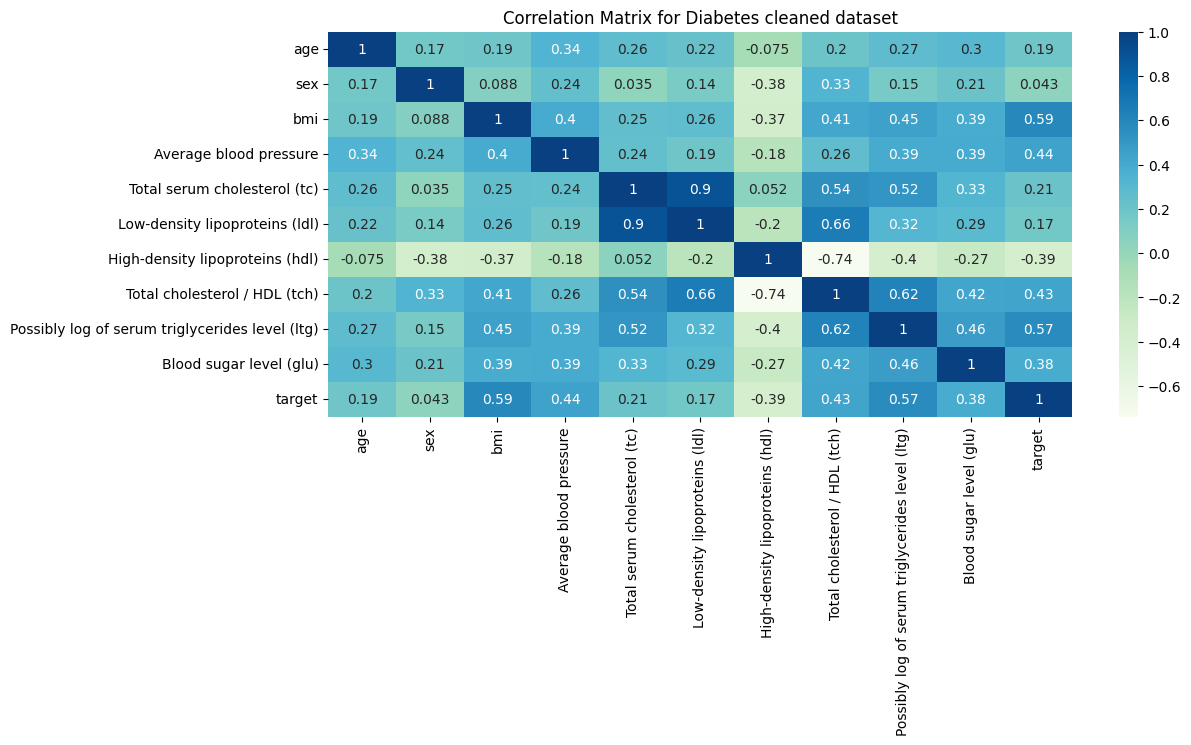

In [257]:
# correlation matrix

corr_mat = data.corr()
plt.figure(figsize=(12,5))
sns.heatmap(data=corr_mat, annot=True, cmap='GnBu')
plt.title("Correlation Matrix for Diabetes cleaned dataset")
plt.show()

**Note that :**
A.correlatio between targert and other veriables are ranked from strong to weak as.
 1.BMI with .59
 2.LTG with .57
 3.ABP with .44
 4.TCH with .43 
 5.HDI with .39
 6.GLU with .38
 7.TC  with .21
 8.AGE with .19
 9.LDL with .17
 10.Gender with .043 
B.correlation between TC and LDL is .9 which is high enough to remove one of them
 The one which will be romoved will be LDL since it has lower correlation with target
c.correlation between target and gender nearly zero so it will be removed as well

In [258]:
data.drop(columns=['Low-density lipoproteins (ldl)'], inplace=True)
data.drop(columns=['sex'], inplace=True)
data.head()


,age,bmi,Average blood pressure,Total serum cholesterol (tc),High-density lipoproteins (hdl),Total cholesterol / HDL (tch),Possibly log of serum triglycerides level (ltg),Blood sugar level (glu),target
0,0.038076,0.061696,0.021872,-0.044223,-0.043401,-0.002592,0.019907,-0.017646,151
1,-0.001882,-0.051474,-0.026328,-0.008449,0.074412,-0.039493,-0.068332,-0.092204,75
2,0.085299,0.044451,-0.005670,-0.045599,-0.032356,-0.002592,0.002861,-0.025930,141
3,-0.089063,-0.011595,-0.036656,0.012191,-0.036038,0.034309,0.022688,-0.009362,206
4,0.005383,-0.036385,0.021872,0.003935,0.008142,-0.002592,-0.031988,-0.046641,135


In [259]:
X_train = data[["age","bmi","Average blood pressure","Total serum cholesterol (tc)","High-density lipoproteins (hdl)","Total cholesterol / HDL (tch)","Possibly log of serum triglycerides level (ltg)"	,"Blood sugar level (glu)"]].values

Y_train = data[["target"]].values

In [260]:
b_init = np.random.uniform(low=-0.1, high=0.1)

w_init = np.random.uniform(low=-0.1, high=0.1, size=(8,))  # 8 weights

print(f"Initial bias (b_init): {b_init:.6f}")
print(f"Initial weights (w_init): {w_init}")

Initial bias (b_init): 0.052074
Initial weights (w_init): [ 0.03202203 -0.09578736 -0.09762999 -0.07514856  0.00470463  0.03498236
  0.01513621 -0.07593572]


In [261]:
# f(x) = w . x + b 
def predict(x, w, b): 
    p = np.dot(x, w) + b     
    return p  

In [262]:
# get a row from our training data
x_vec = X_train[0,:]
print(f"x_vec shape {x_vec.shape}, x_vec value: {x_vec}")

# make a prediction
f_wb = predict(x_vec,w_init, b_init)
print(f"f_wb shape {f_wb.shape}, prediction: {f_wb}")

x_vec shape (8,), x_vec value: [ 0.03807591  0.06169621  0.02187239 -0.0442235  -0.04340085 -0.00259226
  0.01990749 -0.01764612]
f_wb shape (), prediction: 0.04991814717102772


In [263]:
# j(w,b) = 1/(2*m) * sum (f_wb - y)^2 
def compute_cost(X, y, w, b): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0] 
    cost = 0.0 
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return float(cost)

In [264]:
# Compute and display cost using our pre-chosen optimal parameters. 
cost = compute_cost(X_train, Y_train, w_init, b_init)
print(f'Cost at optimal w : {cost}')

Cost at optimal w : 14529.746728743385


C:\Users\dell\AppData\Local\Temp\ipykernel_26932\2145029316.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(cost)


In [265]:
def compute_gradient(X, y, w, b):
    m = X.shape[0]
    n = 8
    dj_dw = np.zeros(w.shape) 
    dj_db = 0.

    for i in range(m):                             
        err = (np.dot(X[i], w) + b) - y[i]   
        for j in range(n):                         
            dj_dw[j] = dj_dw[j] + err.item() * X[i, j]    
        dj_db = dj_db + err                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m
    return dj_db, dj_dw

In [266]:
#Compute and display gradient 
tmp_dj_dw, tmp_dj_db = compute_gradient(X_train, Y_train, w_init, b_init)
print(f'dj_db at initial w,b: {tmp_dj_db}')
print(f'dj_dw at initial w,b: \n {tmp_dj_dw}')

dj_db at initial w,b: [-0.6883102  -2.14839934 -1.61741348 -0.77684749  1.44612038 -1.57686168
 -2.07296155 -1.40128638]
dj_dw at initial w,b: 
 [-152.08140992]


In [267]:
def gradient_descent(x, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      x :    (ndarray): Shape (m,)
      y :    (ndarray): Shape (m,)
      w_in, b_in : (scalar) Initial values of parameters of the model
      cost_function: function to compute cost
      gradient_function: function to compute the gradient
      alpha : (float) Learning rate
      num_iters : (int) number of iterations to run gradient descent
    Returns
      w : (ndarray): Shape (1,) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(x)
    
    # An array to store cost J and w's at each iteration — primarily for graphing later
    J_history = []
    w_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_dw, dj_db = compute_gradient(x, y, w, b )  

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  compute_cost(x, y, w, b)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i % math.ceil(num_iters/10) == 0:
            w_history.append(w)
            print(f"Iteration {i:4}: Cost {float(J_history[-1])}   ")
        
    return w, b, J_history, w_history #return w and J,w history for graphing

In [268]:
# initialize parameters
initial_w = np.zeros_like(w_init)
initial_b = 0.
# some gradient descent settings
iterations = 1000
alpha = 5.0e-7
# run gradient descent 
w_final, b_final, J_hist = gradient_descent(X_train, Y_train, initial_w, initial_b,
                                                    compute_cost, compute_gradient, 
                                                    alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m,_ = X_train.shape
for i in range(m):
    print(f"prediction: {np.dot(X_train[i], w_final) + b_final:0.2f}, target value: {Y_train[i]}")

TypeError: only length-1 arrays can be converted to Python scalars